# Dogs Breads Classification On AWS

**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
Dogs Breads dataset contains 133 different bread of dogs 
the data is divided into train valid test sets we will train the model and try to classify instances in the test set to correct dogs breads

downloading from data source and unzipping

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-12-08 15:20:42--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.194.72
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.194.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  26.5MB/s    in 29s     

2022-12-08 15:21:11 (37.5 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

### Upload data To S3 Bucket to use it with sagemaker Estimator

In [ ]:
import sagemaker 

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "project_data"
path = "dogImages"
role = sagemaker.get_execution_role()

inputs = session.upload_data(path,bucket,prefix)
print(inputs)

s3://sagemaker-us-east-1-538091196942/project_data


In [6]:
import matplotlib.pyplot as plt
#data manipulations
import numpy as np
import pandas as pd
#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
#scraping from internet
from PIL import Image
#scraping from internet
import requests
from io import BytesIO
# time related
from timeit import default_timer as timer

**Loading data from data folder and setting up torch data loader**

In [7]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p = 0.5)
])


# datasets
trainset = torchvision.datasets.ImageFolder("dogImages/train", transform = transforms)
validset = torchvision.datasets.ImageFolder("dogImages/valid", transform = transforms)
testset = torchvision.datasets.ImageFolder("dogImages/test", transform = transforms)

#batches
batch_size = 128

# loaders for data
trainloader = torch.utils.data.DataLoader(trainset , batch_size=batch_size , shuffle = True)
validloader = torch.utils.data.DataLoader(validset , batch_size=batch_size , shuffle = True)
testloader = torch.utils.data.DataLoader(testset  , batch_size=batch_size)

**visualizing some training samples data**

[2022-12-08 15:44:06.962 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-08 15:44:07.379 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


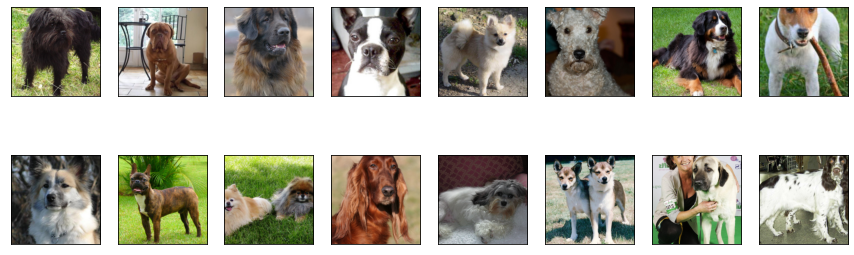

In [8]:
images, labels = iter(trainloader).next()
images, labels = images.numpy() , labels.numpy()

fig = plt.figure(figsize = (15,5))

for i in range(int(batch_size/8)):
    ax = fig.add_subplot(2 , int(batch_size/16) , i + 1 , xticks = [] , yticks = [])
    ax.imshow(np.transpose(images[i] , (1,2,0)) , cmap = 'gray')

## Hyperparameter Tuning

using a pretrained resnet18 model we will fine tune the model on our dogs dataset and find the best values of the learning rate and batch size for training

In [26]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (ContinuousParameter,IntegerParameter,CategoricalParameter,HyperparameterTuner)

hyperparameter_ranges = {'batch-size':CategoricalParameter([32,64,128,256]),
                        'lr':ContinuousParameter(0.001,0.1),
                         'epochs':CategoricalParameter([2,4,6]),}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

**creating Pytorch Sagemaker Estimator to use custom model defiend in hpo.py and hyperparameter tuner to tune it**

In [27]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
                entry_point='hpo.py',
                role=role,
                instance_count=1,
                instance_type='ml.m5.2xlarge',
                framework_version='1.8',
                py_version='py36')

tuner = HyperparameterTuner(estimator,
                           objective_metric_name,
                           hyperparameter_ranges,
                           metric_definitions,
                           max_jobs=4,
                           max_parallel_jobs=2,
                           objective_type=objective_type,
                          )

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({"training":inputs},wait=True) # TODO: Remember to include your data channels

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating hyperparameter tuning job with name: pytorch-training-221208-1632


...................................................................................................................

KeyboardInterrupt: 

In [107]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-12-08 05:33:19 Starting - Preparing the instances for training
2022-12-08 05:33:19 Downloading - Downloading input data
2022-12-08 05:33:19 Training - Training image download completed. Training in progress.
2022-12-08 05:33:19 Uploading - Uploading generated training model
2022-12-08 05:33:19 Completed - Resource reused by training job: pytorch-training-221208-0527-003-c43e1d5b


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '"4"',
 'lr': '0.0030250628797789227',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-12-08-05-27-58-969"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-113877381728/pytorch-training-2022-12-08-05-27-58-969/source/sourcedir.tar.gz"'}

### best hyperparameters combinations found by sagemaker tuner job:
 {'batch-size': '32', 'epochs': '4', 'lr': '0.0030250628797789227'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule,ProfilerRule,rule_configs
from sagemaker.debugger import DebuggerHookConfig,ProfilerConfig,FrameworkProfile

rules = [Rule.sagemaker(rule_configs.vanishing_gradient()),
        Rule.sagemaker(rule_configs.overfit()),
        Rule.sagemaker(rule_configs.overtraining()),
        Rule.sagemaker(rule_configs.poor_weight_initialization()),
        Rule.sagemaker(rule_configs.loss_not_decreasing()),
        ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport()),]


debuger_config = DebuggerHookConfig(hook_parameters={"train.save_interval":"100","eval.save_interval":"10"})
profiler_config = ProfilerConfig(system_monitor_interval_millis=500,framework_profile_params=FrameworkProfile(num_steps=10))

In [ ]:
# TODO: Create and fit an estimator
hyperparameters = {'batch-size': '32','test-batch-size':'32', 'epochs': '6', 'lr': '0.0030250628797789227'}

estimator = PyTorch(
                entry_point='train_model.py',
                role=role,
                instance_count=1,
                instance_type='ml.p2.xlarge',
                hyperparameters= hyperparameters,
                debugger_hook_config= debuger_config,
                profiler_config=profiler_config,
                rules=rules,
                framework_version='1.8',
                py_version='py36')

estimator.fit({"training":inputs},wait=True)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2022-12-08 15:59:35 Starting - Starting the training job...
2022-12-08 16:00:01 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...............
2022-12-08 16:02:29 Downloading - Downloading input data...............
2022-12-08 16:05:03 Training - Downloading the training image..................
2022-12-08 16:08:04 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-08 16:07:56,409 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-08 16:07:56,443 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-08 16:07:56,457 sagemaker_pytorch_container.training INFO     Invoking 

**Debugger Output**

In [195]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [193]:
import time
from IPython import display

%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    #display.clear_output(wait=True)
    time.sleep(100)

TrainingJobStatus:  Completed  | SecondaryStatus:  Completed
VanishingGradient :  NoIssuesFound
Overfit :  Error
Overtraining :  Error
PoorWeightInitialization :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met

LossNotDecreasing :  Error
LowGPUUtilization :  NoIssuesFound
ProfilerReport :  NoIssuesFound
Current time:  Thu Dec  8 07:34:56 2022
TrainingJobStatus:  Completed  | SecondaryStatus:  Completed
VanishingGradient :  NoIssuesFound
Overfit :  Error
Overtraining :  Error
PoorWeightInitialization :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met

LossNotDecreasing :  Error
LowGPUUtilization :  NoIssuesFound
ProfilerReport :  NoIssuesFound
Current time:  Thu Dec  8 07:36:37 2022
TrainingJobStatus:  Completed  | SecondaryStatus:  Completed
VanishingGradient :  NoIssuesFound
Overfit :  Error
Overtraining :  Error
P

KeyboardInterrupt: 

In [16]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor_names()

[2022-12-08 16:28:01.943 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-538091196942/pytorch-training-2022-12-08-15-59-34-782/debug-output
[2022-12-08 16:28:02.689 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-12-08 16:28:03.711 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:32 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_bn1.bias',
 'gradient/ResNet_bn1.weight',
 'gradient/ResNet_conv1.weight',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.3.bias',
 'gradient/ResNet_fc.3.weight',
 'gradient/ResNet_layer1.0.bn1.bias',
 'gradient/ResNet_layer1.0.bn1.weight',
 'gradient/ResNet_layer1.0.bn2.bias',
 'gradient/ResNet_layer1.0.bn2.weight',
 'gradient/ResNet_layer1.0.conv1.weight',
 'gradient/ResNet_layer1.0.conv2.weight',
 'gradient/ResNet_layer1.1.bn1.bias',
 'gradient/ResNet_layer1.1.bn1.weight',
 'gradient/ResNet_layer1.1.bn2.bias',
 'gradient/ResNet_layer1.1.bn2.weight',
 'gradient/ResNet_layer1.1.conv1.weight',
 'gradient/ResNet_layer1.1.conv2.weight',
 'gradient/ResNet_layer2.0.bn1.bias',
 'gradient/ResNet_layer2.0.bn1.weight',
 'gradient/ResNet_layer2.0.bn2.bias',
 'gradient/ResNet_layer2.0.bn2.weight',
 'gradient/ResNet_layer2.0.conv1.weight',
 'gradient/ResNet_layer2.0.conv2.weight',
 'gradient/ResNet_layer2.0.downsa

In [17]:
print(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

[0]


In [18]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [19]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


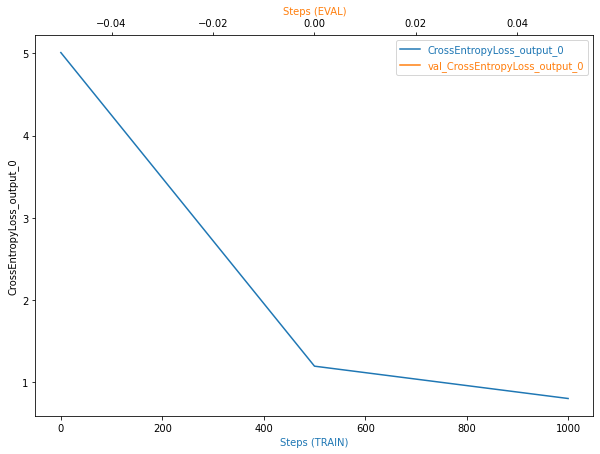

In [20]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [21]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [22]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-12-08 16:27:10     415830 pytorch-training-2022-12-08-15-59-34-782/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-12-08 16:27:10     270468 pytorch-training-2022-12-08-15-59-34-782/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-12-08 16:27:05        192 pytorch-training-2022-12-08-15-59-34-782/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-12-08 16:27:05      63654 pytorch-training-2022-12-08-15-59-34-782/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-12-08 16:27:05       2031 pytorch-training-2022-12-08-15-59-34-782/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-12-08 16:27:05        329 pytorch-training-2022-12-08-15-59-34-782/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-12-08 16:27:05      10218 pytorch-training-2022-12-08-15-59-34-782/rule-output/ProfilerReport/profiler-output/profiler-re

In [23]:
import os
import IPython

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [46]:
# TODO: Deploy your model to an endpoint

predictor=model.deploy(initial_instance_count=1,instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-training-2022-12-08-17-15-57-066
INFO:sagemaker:Creating endpoint with name pytorch-training-2022-12-08-17-15-57-845


-

KeyboardInterrupt: 

In [ ]:
# TODO: Run an prediction on the endpoint
image, label = [x[0] for x in iter(trainloader).next() ]
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()